## X-Ray Abnormality Detection | CNN

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
 * [Create a tensorflow input pipeline for the testing data](#Create-a-tensorflow-input-pipeline-for-the-testing-data)
- [Baseline Performance](#Baseline-Performance)
 * [Random Classification, all study types](#Random-Classification,-all-study-types)
 * [CNN architecture with sensible defaults, all study types](#CNN-architecture-with-sensible-defaults,-all-study-types)
 * [Only on XR_SHOULDER study type](#Only-on-XR_SHOULDER-study-type)
 * [Only on XR_ELBOW study type](#Only-on-XR_ELBOW-study-type)
 * [Only on XR_HUMERUS study type](#Only-on-XR_HUMERUS-study-type)
 * [Only on XR_HAND study type](#Only-on-XR_HAND-study-type)
 * [Only on XR_WRIST study type](#Only-on-XR_WRIST-study-type)
 * [Only on XR_FOREARM study type](#Only-on-XR_FOREARM-study-type)
 * [Only on XR_FINGER study type](#Only-on-XR_FINGER-study-type)


In [1]:
import gc
import os
import pathlib
import random
import re
from glob import glob
from PIL import Image
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import image
from sklearn.metrics import cohen_kappa_score, confusion_matrix


pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-04-01 09:54:18.372407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 09:54:18.400290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 09:54:18.400450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [6]:
DATASET_DIR = "../data/MURA-v1.1/"

In [7]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [8]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['../data/MURA-v1.1/train/XR_WRIST/patient08092/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png',
 '../data/MURA-v1.1/valid/XR_ELBOW/patient11831/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00442/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06289/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient08562/study1_negative/image2.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient04280/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient07018/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06000/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00497/study2_negative/image4.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [9]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [10]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [11]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [12]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [13]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [14]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [15]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [16]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


In [17]:
test_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

In [18]:
test_image_paths["image_path"] = test_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_image_paths["study_type"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
test_image_paths["patient"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
test_image_paths["study"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
test_image_paths["study_path"] = test_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [19]:
test_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

In [20]:
test_labeled_studies["study_path"] = test_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
test_labeled_studies["label"] = test_labeled_studies["label"].map(str)

In [21]:
ref_testset = pd.merge(
    test_image_paths, test_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_testset)

shape: (3197, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
2,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
3,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,XR_WRIST,patient11185,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
4,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,XR_WRIST,patient11186,study1_positive,../data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [22]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [23]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2,
)

In [24]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [25]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


#### Create a tensorflow input pipeline for the testing data

In [26]:
testing = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
)

In [27]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
)

Found 3197 validated image filenames belonging to 2 classes.


### Baseline Performance

We will try to establish, through some very basic architectures (from naive random classification to a simple CNN) the complexity of the problem.

This is very important, as it will serve as a reference on our efforts to find a better-suited architecture for the problem.

#### Random Classification, all study types

In [28]:
class RandomClassifier(object):
    """Random classifier - predicts whether an image is normal or abnormal at random."""

    def predict(self, image_path: str) -> float:

        return random.random()

In [29]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [30]:
model = RandomClassifier()

temp_testset["prediction"] = temp_testset["image_path"].map(model.predict)

In [31]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(temp_testset["prediction"].values),
)

0.0049013669964691475

We now have to aggregate all the predictions - in a meaningful way - at the study level.

We will assume that if the majority of the images of a given study are classified as abnormal, then the study will be classified as abnormal as well (and vice versa).

In [32]:
def study_oriented_transformation(dataset: pd.DataFrame) -> Iterable:

    for study, group in dataset.groupby("study_path"):

        study_label = group["label"].values.take(0)
        study_prediction = 1 if group["prediction"].mean() > 0.5 else 0

        yield study, study_label, study_prediction

In [33]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [34]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

-0.02330674545107736

In [35]:
del temp_testset
del model

#### CNN architecture with sensible defaults, all study types

In [36]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [37]:
# the tfa.metrics.F1Score (https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score)
# requires some reshaping that is inconsistent with the other metrics we like to track
# so we will define it from scratch


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [38]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

2022-04-01 09:54:23.078470: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 09:54:23.079267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 09:54:23.079550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 09:54:23.079734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [39]:
def plot_metrics(
    history: tf.keras.callbacks.History,
    metrics: list = ["loss", "cohen_kappa", "precision", "recall"],
) -> None:

    plt.rcParams["figure.figsize"] = (18, 15)

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(
            history.epoch, history.history[metric], linewidth=1.8, label="training"
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            linestyle="--",
            linewidth=1.8,
            label="validation",
        )
        plt.xlabel("epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "cohen_kappa":
            plt.ylim([-1, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

In [40]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="1st-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="2nd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="2nd-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="3rd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="3rd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="3rd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="3rd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=32,
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [41]:
model = make_cnn_model()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 224, 224, 32)      896       
                                                                 
 1st-batch-norm (BatchNormal  (None, 224, 224, 32)     128       
 ization)                                                        
                                                                 
 1st-max-pooling (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 112, 112, 32)      0         
                                                                 
 2nd-convolution (Conv2D)    (None, 112, 112, 64)      18496     
                                                                 
 2nd-batch-norm (BatchNormal  (None, 112, 112, 64)     2

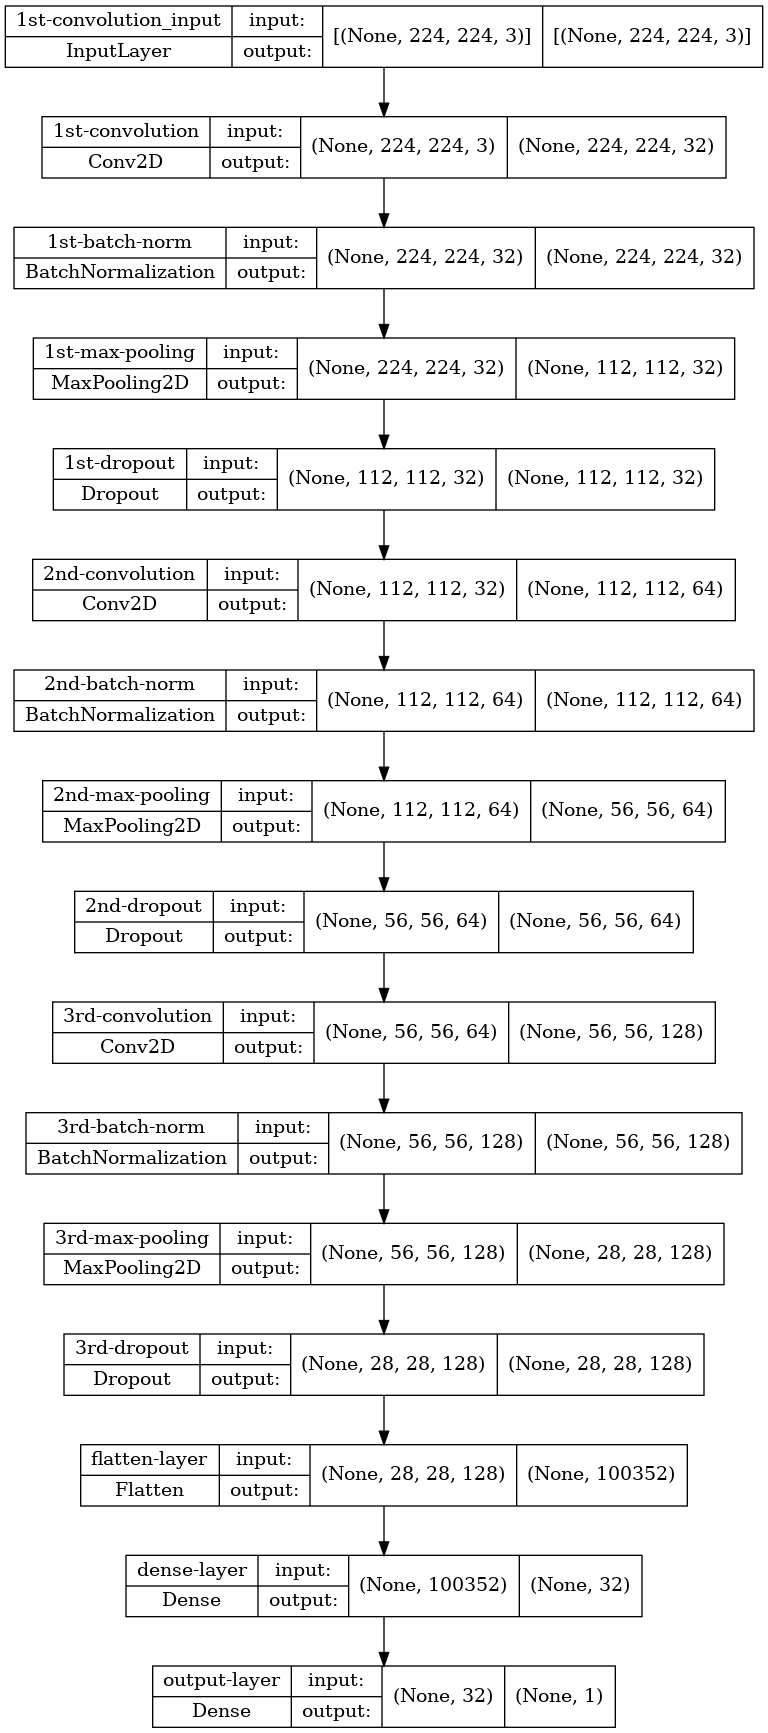

In [43]:
tf.keras.utils.plot_model(
    model,
    to_file="../static/cnn-all-study-types-3305473.png",
    show_shapes=True,
    show_layer_names=True,
)

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
)

In [45]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.2, verbose=1, patience=5, min_lr=1e-6
)

In [46]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100


2022-04-01 09:54:27.787650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


921/921 [==============================] - 330s 352ms/step - loss: 1.9246 - tp: 148.0000 - fp: 191.0000 - tn: 18551.0000 - fn: 10557.0000 - binary_acc: 0.6350 - precision: 0.4366 - recall: 0.0138 - f1_score: 0.0268 - roc_auc: 0.6005 - pr_auc: 0.4364 - cohen_kappa: 0.0046 - val_loss: 1.4331 - val_tp: 102.0000 - val_fp: 70.0000 - val_tn: 3123.0000 - val_fn: 4066.0000 - val_binary_acc: 0.4381 - val_precision: 0.5930 - val_recall: 0.0245 - val_f1_score: 0.0470 - val_roc_auc: 0.5271 - val_pr_auc: 0.5791 - val_cohen_kappa: 0.0022 - lr: 1.0000e-04
Epoch 2/100
921/921 [==============================] - 342s 371ms/step - loss: 1.0705 - tp: 114.0000 - fp: 142.0000 - tn: 18600.0000 - fn: 10591.0000 - binary_acc: 0.6355 - precision: 0.4453 - recall: 0.0106 - f1_score: 0.0208 - roc_auc: 0.6242 - pr_auc: 0.4568 - cohen_kappa: 0.0039 - val_loss: 1.0888 - val_tp: 14.0000 - val_fp: 18.0000 - val_tn: 3175.0000 - val_fn: 4154.0000 - val_binary_acc: 0.4332 - val_precision: 0.4375 - val_recall: 0.0034 - va

921/921 [==============================] - 368s 399ms/step - loss: 0.5851 - tp: 4916.0000 - fp: 1943.0000 - tn: 16799.0000 - fn: 5789.0000 - binary_acc: 0.7374 - precision: 0.7167 - recall: 0.4592 - f1_score: 0.5598 - roc_auc: 0.7860 - pr_auc: 0.6544 - cohen_kappa: 0.3852 - val_loss: 1.1995 - val_tp: 220.0000 - val_fp: 70.0000 - val_tn: 3123.0000 - val_fn: 3948.0000 - val_binary_acc: 0.4542 - val_precision: 0.7586 - val_recall: 0.0528 - val_f1_score: 0.0987 - val_roc_auc: 0.5599 - val_pr_auc: 0.6300 - val_cohen_kappa: 0.0270 - lr: 2.0000e-05
Epoch 16/100
921/921 [==============================] - 387s 420ms/step - loss: 0.5814 - tp: 4885.0000 - fp: 1854.0000 - tn: 16888.0000 - fn: 5820.0000 - binary_acc: 0.7394 - precision: 0.7249 - recall: 0.4563 - f1_score: 0.5601 - roc_auc: 0.7909 - pr_auc: 0.6638 - cohen_kappa: 0.3882 - val_loss: 1.1898 - val_tp: 253.0000 - val_fp: 78.0000 - val_tn: 3115.0000 - val_fn: 3915.0000 - val_binary_acc: 0.4575 - val_precision: 0.7644 - val_recall: 0.0607 

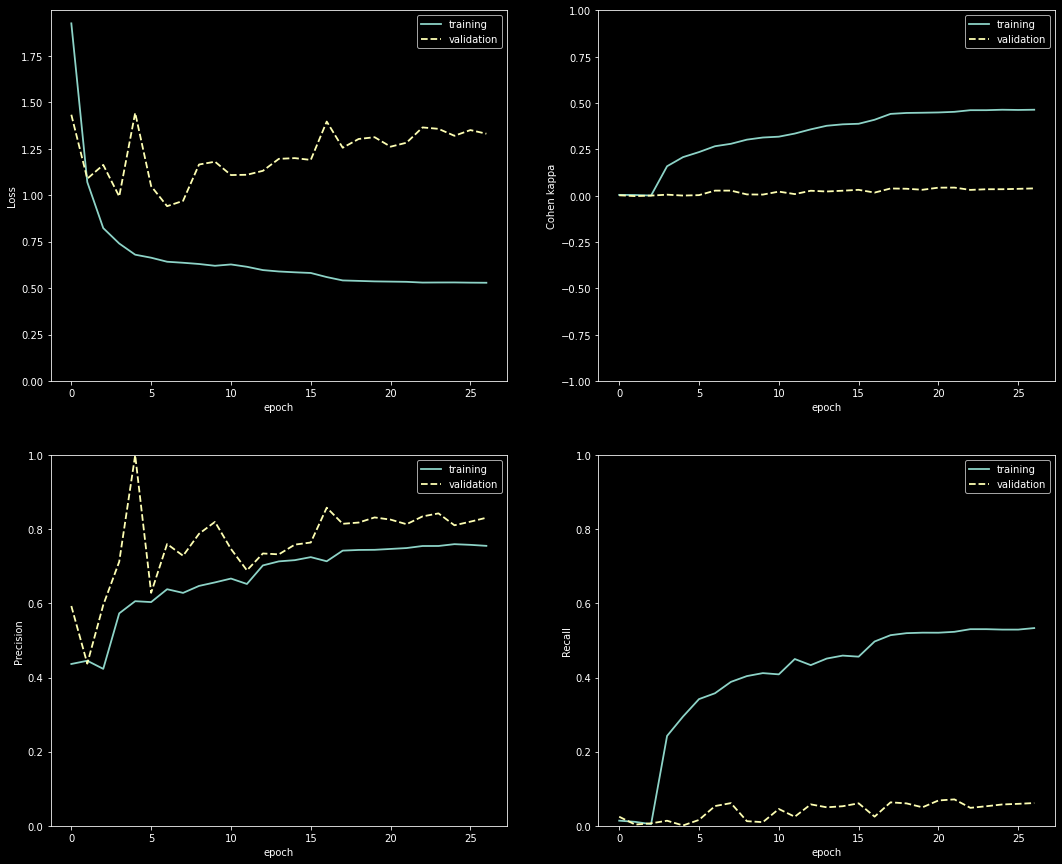

In [47]:
plot_metrics(history)

In [48]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

100/100 [==============================] - 10s 97ms/step - loss: 0.7779 - tp: 479.0000 - fp: 64.0000 - tn: 1603.0000 - fn: 1051.0000 - binary_acc: 0.6512 - precision: 0.8821 - recall: 0.3131 - f1_score: 0.4621 - roc_auc: 0.7483 - pr_auc: 0.7691 - cohen_kappa: 0.2822


In [49]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 0.777926504611969
tp          : 479.0
fp          : 64.0
tn          : 1603.0
fn          : 1051.0
binary_acc  : 0.6512355208396912
precision   : 0.8821362853050232
recall      : 0.3130719065666199
f1_score    : 0.46213221549987793
roc_auc     : 0.748303234577179
pr_auc      : 0.7691205143928528
cohen_kappa : 0.28215914964675903


In [50]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

100/100 [==============================] - 8s 79ms/step


In [51]:
temp_testset = ref_testset.copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [52]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.2821591118935294

In [53]:
temp_testset["prediction"] = preds.ravel()

In [54]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [55]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

0.3162037113266263

In [56]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-all-study-types-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-all-study-types-3305473.h5")

In [57]:
clean_up(model)
del temp_testset

#### Only on XR_SHOULDER study type

In [58]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 6704 validated image filenames belonging to 2 classes.


In [59]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1675 validated image filenames belonging to 2 classes.


In [60]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

Found 563 validated image filenames belonging to 2 classes.


In [61]:
model = make_cnn_model()

In [62]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
210/210 [==============================] - 100s 466ms/step - loss: 2.4767 - tp: 583.0000 - fp: 195.0000 - tn: 5611.0000 - fn: 3512.0000 - binary_acc: 0.6256 - precision: 0.7494 - recall: 0.1424 - f1_score: 0.2393 - roc_auc: 0.5655 - pr_auc: 0.5129 - cohen_kappa: 0.1235 - val_loss: 18.1717 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1603.0000 - val_binary_acc: 0.0430 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.9570 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
210/210 [==============================] - 88s 417ms/step - loss: 1.9829 - tp: 66.0000 - fp: 47.0000 - tn: 4092.0000 - fn: 2499.0000 - binary_acc: 0.6202 - precision: 0.5841 - recall: 0.0257 - f1_score: 0.0493 - roc_auc: 0.5539 - pr_auc: 0.4324 - cohen_kappa: 0.0176 - val_loss: 10.6201 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1603.0000 - val_binary_acc: 0.0430 - val_precision: 0.

Epoch 16/100
210/210 [==============================] - 84s 399ms/step - loss: 0.6696 - tp: 1195.0000 - fp: 492.0000 - tn: 3647.0000 - fn: 1370.0000 - binary_acc: 0.7223 - precision: 0.7084 - recall: 0.4659 - f1_score: 0.5621 - roc_auc: 0.7609 - pr_auc: 0.6912 - cohen_kappa: 0.3712 - val_loss: 0.9815 - val_tp: 599.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1004.0000 - val_binary_acc: 0.4006 - val_precision: 1.0000 - val_recall: 0.3737 - val_f1_score: 0.5441 - val_roc_auc: 0.7809 - val_pr_auc: 0.9880 - val_cohen_kappa: 0.0488 - lr: 2.0000e-05
Epoch 17/100
210/210 [==============================] - 83s 394ms/step - loss: 0.6617 - tp: 1223.0000 - fp: 480.0000 - tn: 3659.0000 - fn: 1342.0000 - binary_acc: 0.7282 - precision: 0.7181 - recall: 0.4768 - f1_score: 0.5731 - roc_auc: 0.7679 - pr_auc: 0.6965 - cohen_kappa: 0.3855 - val_loss: 1.1510 - val_tp: 444.0000 - val_fp: 1.0000 - val_tn: 71.0000 - val_fn: 1159.0000 - val_binary_acc: 0.3075 - val_precision: 0.9978 - val_recall: 0.

Epoch 30/100
210/210 [==============================] - 84s 400ms/step - loss: 0.6237 - tp: 1277.0000 - fp: 388.0000 - tn: 3751.0000 - fn: 1288.0000 - binary_acc: 0.7500 - precision: 0.7670 - recall: 0.4979 - f1_score: 0.6038 - roc_auc: 0.7910 - pr_auc: 0.7328 - cohen_kappa: 0.4330 - val_loss: 1.0307 - val_tp: 668.0000 - val_fp: 5.0000 - val_tn: 67.0000 - val_fn: 935.0000 - val_binary_acc: 0.4388 - val_precision: 0.9926 - val_recall: 0.4167 - val_f1_score: 0.5870 - val_roc_auc: 0.7929 - val_pr_auc: 0.9881 - val_cohen_kappa: 0.0484 - lr: 1.0000e-06
Epoch 30: early stopping


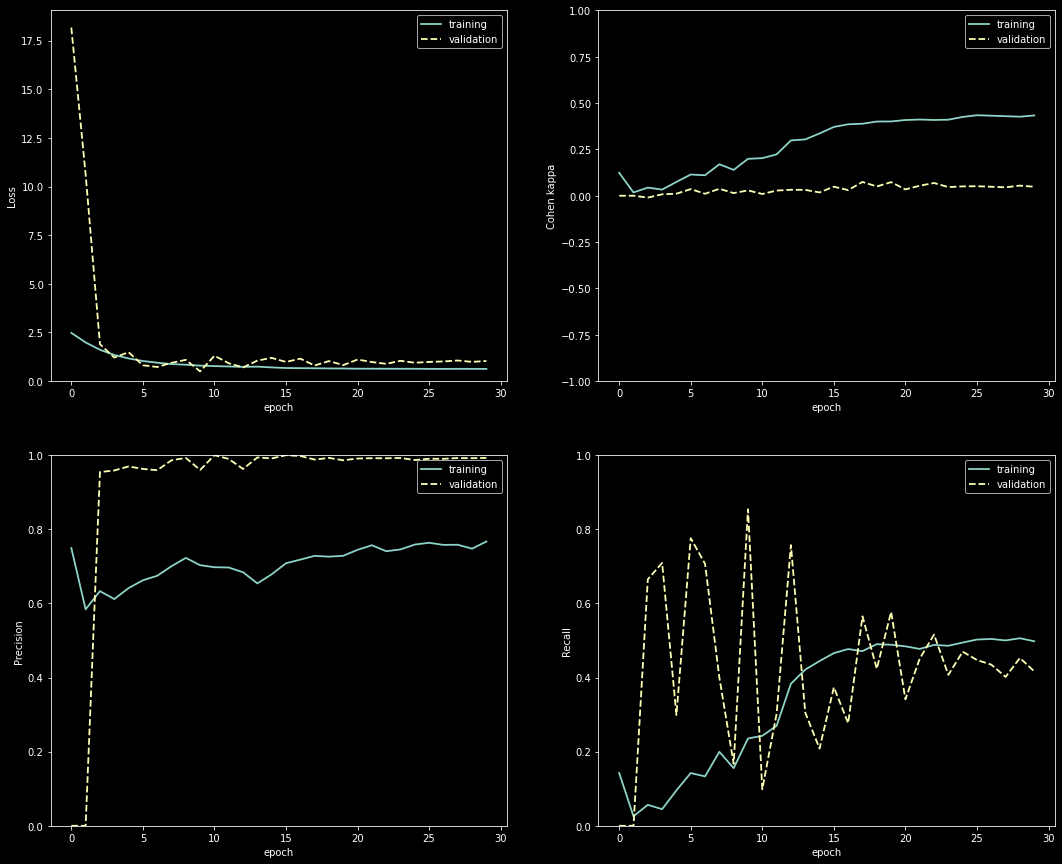

In [63]:
plot_metrics(history)

In [64]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

18/18 [==============================] - 2s 109ms/step - loss: 0.7327 - tp: 186.0000 - fp: 108.0000 - tn: 177.0000 - fn: 92.0000 - binary_acc: 0.6448 - precision: 0.6327 - recall: 0.6691 - f1_score: 0.6503 - roc_auc: 0.7144 - pr_auc: 0.7392 - cohen_kappa: 0.2899


In [65]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 0.7327109575271606
tp          : 186.0
fp          : 108.0
tn          : 177.0
fn          : 92.0
binary_acc  : 0.6447601914405823
precision   : 0.6326530575752258
recall      : 0.6690647602081299
f1_score    : 0.6503496766090393
roc_auc     : 0.714369535446167
pr_auc      : 0.7391712665557861
cohen_kappa : 0.2899124026298523


In [66]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

18/18 [==============================] - 1s 79ms/step


In [67]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_SHOULDER"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [68]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.2899124687838963

In [69]:
temp_testset["prediction"] = preds.ravel()

In [70]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [71]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

0.3613677391950727

In [72]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_SHOULDER-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_SHOULDER-3305473.h5")

In [73]:
clean_up(model)
del temp_testset

#### Only on XR_ELBOW study type

In [74]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 3945 validated image filenames belonging to 2 classes.


In [75]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 986 validated image filenames belonging to 2 classes.


In [76]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

Found 465 validated image filenames belonging to 2 classes.


In [77]:
model = make_cnn_model()

In [78]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
124/124 [==============================] - 51s 394ms/step - loss: 2.5034 - tp: 214.0000 - fp: 196.0000 - tn: 2992.0000 - fn: 1106.0000 - binary_acc: 0.7112 - precision: 0.5220 - recall: 0.1621 - f1_score: 0.2474 - roc_auc: 0.6239 - pr_auc: 0.4306 - cohen_kappa: 0.1261 - val_loss: 13.2251 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 22.0000 - val_fn: 964.0000 - val_binary_acc: 0.0223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.9777 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
124/124 [==============================] - 55s 441ms/step - loss: 2.1883 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2903.0000 - fn: 1042.0000 - binary_acc: 0.7359 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.6297 - pr_auc: 0.3547 - cohen_kappa: 0.0000e+00 - val_loss: 13.5522 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 22.0000 - val_fn: 964.0000 - val_binary_acc: 0.0223 

124/124 [==============================] - 52s 418ms/step - loss: 0.7943 - tp: 0.0000e+00 - fp: 3.0000 - tn: 2900.0000 - fn: 1042.0000 - binary_acc: 0.7351 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.6679 - pr_auc: 0.3848 - cohen_kappa: -0.0015 - val_loss: 1.8513 - val_tp: 24.0000 - val_fp: 0.0000e+00 - val_tn: 22.0000 - val_fn: 940.0000 - val_binary_acc: 0.0467 - val_precision: 1.0000 - val_recall: 0.0249 - val_f1_score: 0.0486 - val_roc_auc: 0.7375 - val_pr_auc: 0.9919 - val_cohen_kappa: 0.0011 - lr: 1.0000e-04
Epoch 16/100
124/124 [==============================] - 52s 415ms/step - loss: 0.7690 - tp: 3.0000 - fp: 2.0000 - tn: 2901.0000 - fn: 1039.0000 - binary_acc: 0.7361 - precision: 0.6000 - recall: 0.0029 - f1_score: 0.0057 - roc_auc: 0.6677 - pr_auc: 0.3850 - cohen_kappa: 0.0032 - val_loss: 1.1884 - val_tp: 213.0000 - val_fp: 1.0000 - val_tn: 21.0000 - val_fn: 751.0000 - val_binary_acc: 0.2373 - val_precision: 0.9953 - val_recall: 0.2210 - va

124/124 [==============================] - 51s 409ms/step - loss: 0.6479 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2903.0000 - fn: 1042.0000 - binary_acc: 0.7359 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.7285 - pr_auc: 0.4801 - cohen_kappa: 0.0000e+00 - val_loss: 1.9915 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 22.0000 - val_fn: 964.0000 - val_binary_acc: 0.0223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.7276 - val_pr_auc: 0.9917 - val_cohen_kappa: 0.0000e+00 - lr: 4.0000e-06
Epoch 29/100
124/124 [==============================] - 47s 380ms/step - loss: 0.6446 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2903.0000 - fn: 1041.0000 - binary_acc: 0.7361 - precision: 1.0000 - recall: 9.5969e-04 - f1_score: 0.0019 - roc_auc: 0.7331 - pr_auc: 0.4881 - cohen_kappa: 0.0014 - val_loss: 2.0088 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 22.0000 - val_fn: 964.0000 - val_binary_acc: 0.0223 - val_pre

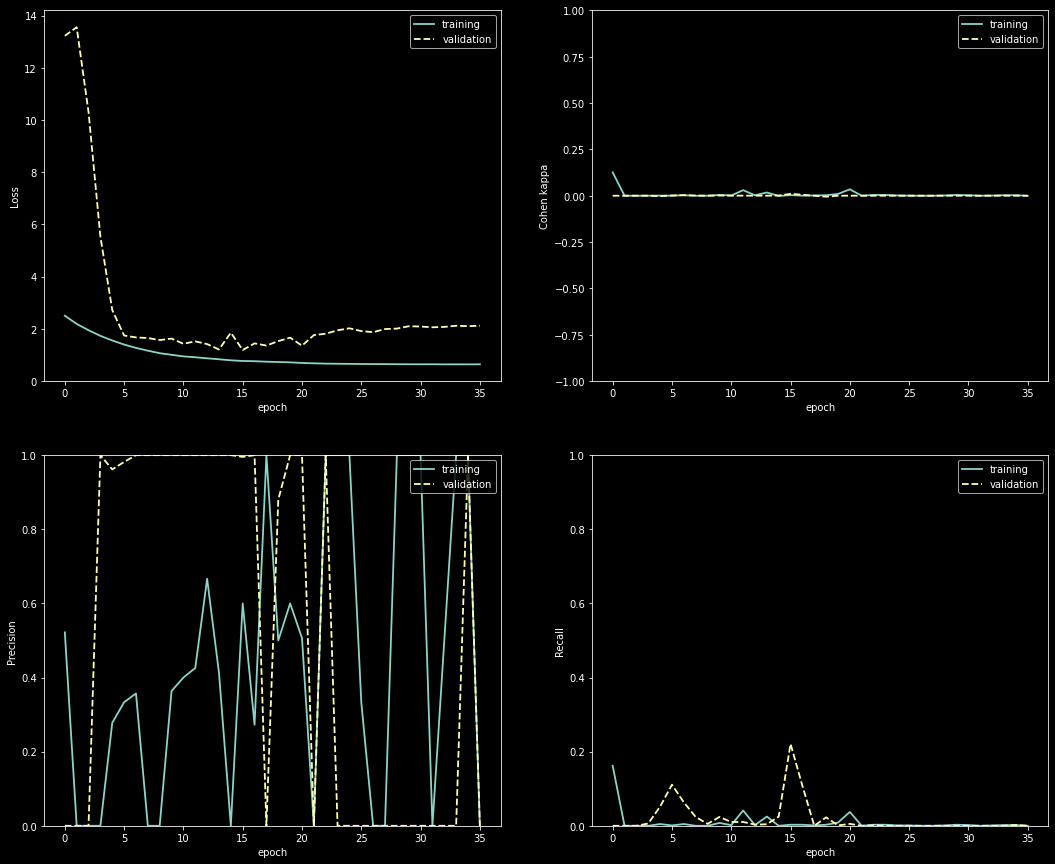

In [79]:
plot_metrics(history)

In [80]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

15/15 [==============================] - 2s 135ms/step - loss: 1.2073 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235.0000 - fn: 230.0000 - binary_acc: 0.5054 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.6593 - pr_auc: 0.6141 - cohen_kappa: 0.0000e+00


In [81]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 1.2073477506637573
tp          : 0.0
fp          : 0.0
tn          : 235.0
fn          : 230.0
binary_acc  : 0.5053763389587402
precision   : 0.0
recall      : 0.0
f1_score    : 0.0
roc_auc     : 0.6593431830406189
pr_auc      : 0.6140667796134949
cohen_kappa : 0.0


In [82]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

15/15 [==============================] - 1s 92ms/step


In [83]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_ELBOW"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [84]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.0

In [85]:
temp_testset["prediction"] = preds.ravel()

In [86]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [87]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

0.0

In [88]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_ELBOW-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_ELBOW-3305473.h5")

In [89]:
clean_up(model)
del temp_testset

#### Only on XR_HUMERUS study type

In [90]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 1018 validated image filenames belonging to 2 classes.


In [91]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 254 validated image filenames belonging to 2 classes.


In [92]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

Found 288 validated image filenames belonging to 2 classes.


In [93]:
model = make_cnn_model()

In [94]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
32/32 [==============================] - 17s 470ms/step - loss: 2.6602 - tp: 85.0000 - fp: 104.0000 - tn: 802.0000 - fn: 492.0000 - binary_acc: 0.5981 - precision: 0.4497 - recall: 0.1473 - f1_score: 0.2219 - roc_auc: 0.5427 - pr_auc: 0.4215 - cohen_kappa: 0.0370 - val_loss: 3.0655 - val_tp: 19.0000 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 233.0000 - val_binary_acc: 0.0827 - val_precision: 1.0000 - val_recall: 0.0754 - val_f1_score: 0.1402 - val_roc_auc: 0.8651 - val_pr_auc: 0.9988 - val_cohen_kappa: 0.0013 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - 12s 371ms/step - loss: 2.5152 - tp: 96.0000 - fp: 112.0000 - tn: 559.0000 - fn: 251.0000 - binary_acc: 0.6434 - precision: 0.4615 - recall: 0.2767 - f1_score: 0.3459 - roc_auc: 0.6413 - pr_auc: 0.4505 - cohen_kappa: 0.1215 - val_loss: 3.6328 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 252.0000 - val_binary_acc: 0.0079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 

Epoch 15/100
32/32 [==============================] - 14s 436ms/step - loss: 2.0080 - tp: 128.0000 - fp: 72.0000 - tn: 599.0000 - fn: 219.0000 - binary_acc: 0.7141 - precision: 0.6400 - recall: 0.3689 - f1_score: 0.4680 - roc_auc: 0.7694 - pr_auc: 0.6191 - cohen_kappa: 0.2914 - val_loss: 3.6185 - val_tp: 35.0000 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 217.0000 - val_binary_acc: 0.1457 - val_precision: 1.0000 - val_recall: 0.1389 - val_f1_score: 0.2439 - val_roc_auc: 0.6042 - val_pr_auc: 0.9960 - val_cohen_kappa: 0.0025 - lr: 4.0000e-06
Epoch 16/100
32/32 [==============================] - ETA: 0s - loss: 2.0173 - tp: 138.0000 - fp: 71.0000 - tn: 600.0000 - fn: 209.0000 - binary_acc: 0.7250 - precision: 0.6603 - recall: 0.3977 - f1_score: 0.4964 - roc_auc: 0.7555 - pr_auc: 0.6034 - cohen_kappa: 0.3229
Epoch 16: ReduceLROnPlateau reducing learning rate to 1e-06.
32/32 [==============================] - 13s 410ms/step - loss: 2.0173 - tp: 138.0000 - fp: 71.0000 - tn: 600.0000 - fn

32/32 [==============================] - 13s 393ms/step - loss: 2.0114 - tp: 140.0000 - fp: 89.0000 - tn: 582.0000 - fn: 207.0000 - binary_acc: 0.7092 - precision: 0.6114 - recall: 0.4035 - f1_score: 0.4861 - roc_auc: 0.7441 - pr_auc: 0.5847 - cohen_kappa: 0.2950 - val_loss: 2.7627 - val_tp: 55.0000 - val_fp: 1.0000 - val_tn: 1.0000 - val_fn: 197.0000 - val_binary_acc: 0.2205 - val_precision: 0.9821 - val_recall: 0.2183 - val_f1_score: 0.3571 - val_roc_auc: 0.5010 - val_pr_auc: 0.9914 - val_cohen_kappa: -0.0057 - lr: 1.0000e-06
Epoch 30/100
32/32 [==============================] - 12s 388ms/step - loss: 2.0006 - tp: 131.0000 - fp: 71.0000 - tn: 600.0000 - fn: 216.0000 - binary_acc: 0.7181 - precision: 0.6485 - recall: 0.3775 - f1_score: 0.4772 - roc_auc: 0.7521 - pr_auc: 0.6101 - cohen_kappa: 0.3022 - val_loss: 2.8090 - val_tp: 62.0000 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 190.0000 - val_binary_acc: 0.2520 - val_precision: 1.0000 - val_recall: 0.2460 - val_f1_score: 0.3949 - 

Epoch 44/100
32/32 [==============================] - 15s 464ms/step - loss: 1.9736 - tp: 139.0000 - fp: 71.0000 - tn: 600.0000 - fn: 208.0000 - binary_acc: 0.7259 - precision: 0.6619 - recall: 0.4006 - f1_score: 0.4991 - roc_auc: 0.7744 - pr_auc: 0.6308 - cohen_kappa: 0.3258 - val_loss: 2.7823 - val_tp: 58.0000 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 194.0000 - val_binary_acc: 0.2362 - val_precision: 1.0000 - val_recall: 0.2302 - val_f1_score: 0.3742 - val_roc_auc: 0.9464 - val_pr_auc: 0.9996 - val_cohen_kappa: 0.0047 - lr: 1.0000e-06
Epoch 45/100
32/32 [==============================] - 16s 483ms/step - loss: 1.9903 - tp: 137.0000 - fp: 70.0000 - tn: 601.0000 - fn: 210.0000 - binary_acc: 0.7250 - precision: 0.6618 - recall: 0.3948 - f1_score: 0.4946 - roc_auc: 0.7482 - pr_auc: 0.5913 - cohen_kappa: 0.3218 - val_loss: 2.8092 - val_tp: 54.0000 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 198.0000 - val_binary_acc: 0.2205 - val_precision: 1.0000 - val_recall: 0.2143 - val_f1_

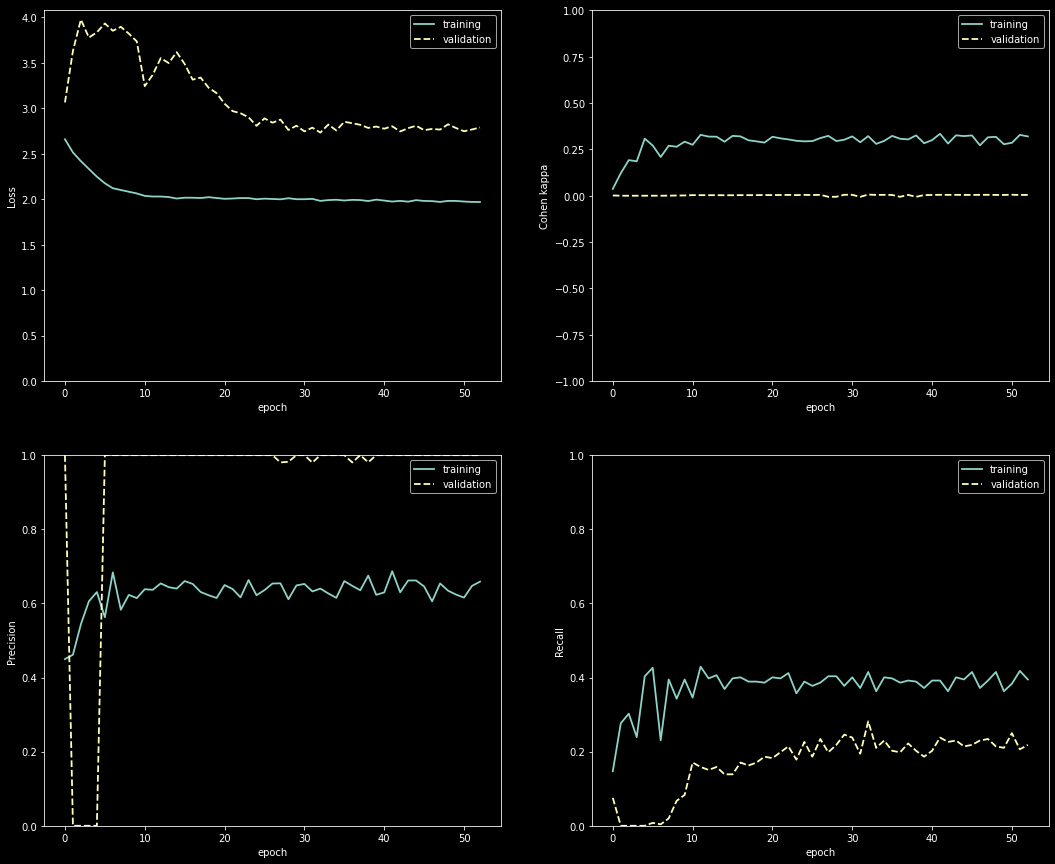

In [95]:
plot_metrics(history)

In [96]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

9/9 [==============================] - 1s 105ms/step - loss: 2.2387 - tp: 31.0000 - fp: 19.0000 - tn: 129.0000 - fn: 109.0000 - binary_acc: 0.5556 - precision: 0.6200 - recall: 0.2214 - f1_score: 0.3263 - roc_auc: 0.6538 - pr_auc: 0.5996 - cohen_kappa: 0.0947


In [97]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 2.2386891841888428
tp          : 31.0
fp          : 19.0
tn          : 129.0
fn          : 109.0
binary_acc  : 0.5555555820465088
precision   : 0.6200000047683716
recall      : 0.22142857313156128
f1_score    : 0.3263157606124878
roc_auc     : 0.6537886261940002
pr_auc      : 0.5996074676513672
cohen_kappa : 0.0946955680847168


In [98]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

9/9 [==============================] - 1s 101ms/step


In [99]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_HUMERUS"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [100]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.09469548133595285

In [101]:
temp_testset["prediction"] = preds.ravel()

In [102]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [103]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

0.01677333921871549

In [104]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_HUMERUS-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_HUMERUS-3305473.h5")

In [105]:
clean_up(model)
del temp_testset

#### Only on XR_HAND study type

In [106]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 4435 validated image filenames belonging to 2 classes.


In [107]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1108 validated image filenames belonging to 2 classes.


In [108]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

Found 460 validated image filenames belonging to 2 classes.


In [109]:
model = make_cnn_model()

In [110]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
139/139 [==============================] - 67s 463ms/step - loss: 2.2283 - tp: 33.0000 - fp: 40.0000 - tn: 4114.0000 - fn: 536.0000 - binary_acc: 0.8780 - precision: 0.4521 - recall: 0.0580 - f1_score: 0.1028 - roc_auc: 0.6385 - pr_auc: 0.2207 - cohen_kappa: 0.0775 - val_loss: 2.5980 - val_tp: 1055.0000 - val_fp: 53.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.9522 - val_precision: 0.9522 - val_recall: 1.0000 - val_f1_score: 0.9755 - val_roc_auc: 0.5000 - val_pr_auc: 0.9522 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
139/139 [==============================] - 66s 475ms/step - loss: 1.8180 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4006.0000 - fn: 429.0000 - binary_acc: 0.9033 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.6183 - pr_auc: 0.1351 - cohen_kappa: 5.9605e-08 - val_loss: 2.1624 - val_tp: 1055.0000 - val_fp: 53.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.9522 - val_precision:

139/139 [==============================] - 55s 397ms/step - loss: 0.6778 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4006.0000 - fn: 429.0000 - binary_acc: 0.9033 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.7017 - pr_auc: 0.2200 - cohen_kappa: 5.9605e-08 - val_loss: 1.7648 - val_tp: 14.0000 - val_fp: 0.0000e+00 - val_tn: 53.0000 - val_fn: 1041.0000 - val_binary_acc: 0.0605 - val_precision: 1.0000 - val_recall: 0.0133 - val_f1_score: 0.0262 - val_roc_auc: 0.6200 - val_pr_auc: 0.9651 - val_cohen_kappa: 0.0013 - lr: 4.0000e-06
Epoch 15/100
139/139 [==============================] - 61s 437ms/step - loss: 0.6706 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4006.0000 - fn: 429.0000 - binary_acc: 0.9033 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.7178 - pr_auc: 0.2362 - cohen_kappa: 5.9605e-08 - val_loss: 1.7718 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 53.0000 - val_fn: 1047.0000 - val_binary_acc: 0.0551 - val_precision:

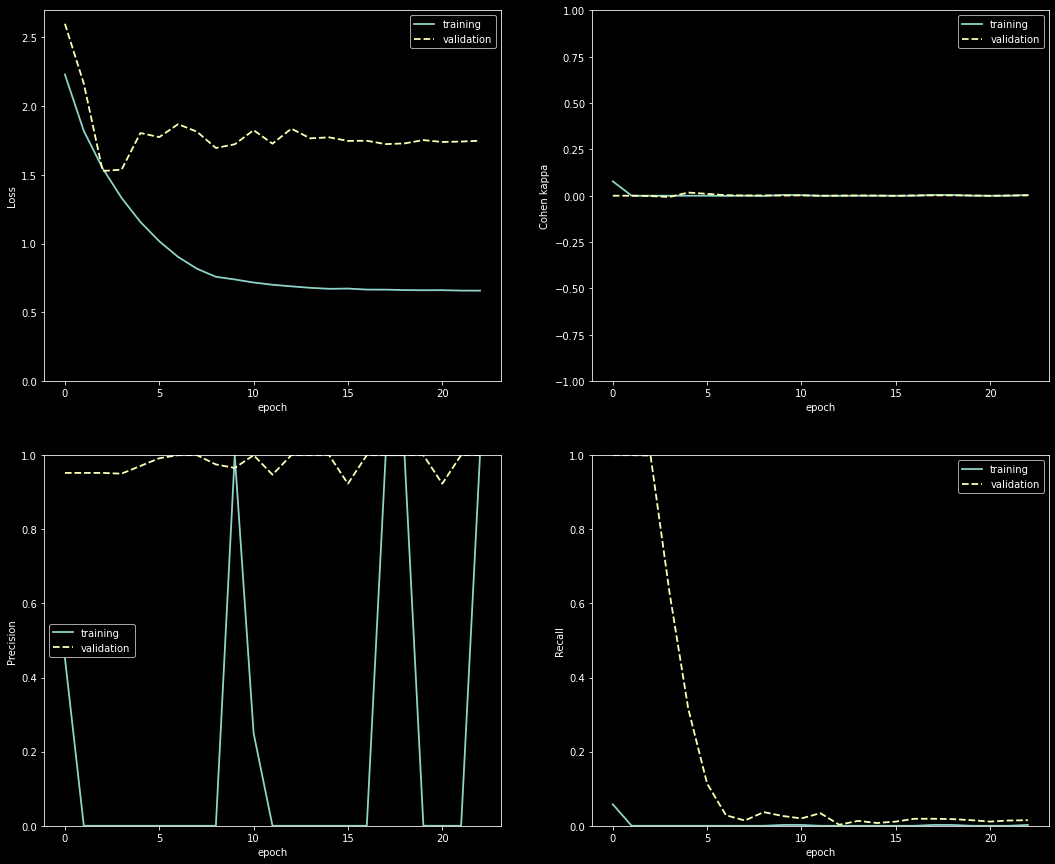

In [111]:
plot_metrics(history)

In [112]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

15/15 [==============================] - 2s 131ms/step - loss: 1.1278 - tp: 8.0000 - fp: 7.0000 - tn: 264.0000 - fn: 181.0000 - binary_acc: 0.5913 - precision: 0.5333 - recall: 0.0423 - f1_score: 0.0784 - roc_auc: 0.5661 - pr_auc: 0.4632 - cohen_kappa: 0.0192


In [113]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

test loss   : 1.1277841329574585
tp          : 8.0
fp          : 7.0
tn          : 264.0
fn          : 181.0
binary_acc  : 0.591304361820221
precision   : 0.5333333611488342
recall      : 0.042328041046857834
f1_score    : 0.07843136787414551
roc_auc     : 0.5660594701766968
pr_auc      : 0.46324700117111206
cohen_kappa : 0.01916748285293579


In [114]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

15/15 [==============================] - 2s 97ms/step


In [115]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_HAND"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [116]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

0.01916751729613242

In [117]:
temp_testset["prediction"] = preds.ravel()

In [118]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [119]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

0.024445043587669746

In [120]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_HAND-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_HAND-3305473.h5")

In [121]:
clean_up(model)
del temp_testset

#### Only on XR_WRIST study type

In [122]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 7802 validated image filenames belonging to 2 classes.


In [123]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

Found 1950 validated image filenames belonging to 2 classes.


In [124]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

Found 659 validated image filenames belonging to 2 classes.


In [125]:
model = make_cnn_model()

In [ ]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
244/244 [==============================] - 115s 465ms/step - loss: 2.4102 - tp: 70.0000 - fp: 107.0000 - tn: 5798.0000 - fn: 2287.0000 - binary_acc: 0.7102 - precision: 0.3955 - recall: 0.0297 - f1_score: 0.0552 - roc_auc: 0.5621 - pr_auc: 0.3222 - cohen_kappa: 0.0160 - val_loss: 14.3340 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 131.0000 - val_fn: 1819.0000 - val_binary_acc: 0.0672 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.9328 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
244/244 [==============================] - 106s 435ms/step - loss: 1.9541 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 5634.0000 - fn: 2168.0000 - binary_acc: 0.7221 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.5794 - pr_auc: 0.3166 - cohen_kappa: 0.0000e+00 - val_loss: 3.7487 - val_tp: 103.0000 - val_fp: 9.0000 - val_tn: 122.0000 - val_fn: 1716.0000 - val_binary_acc: 0.1154 - 

Epoch 15/100
244/244 [==============================] - 107s 438ms/step - loss: 0.6457 - tp: 12.0000 - fp: 2.0000 - tn: 5632.0000 - fn: 2156.0000 - binary_acc: 0.7234 - precision: 0.8571 - recall: 0.0055 - f1_score: 0.0110 - roc_auc: 0.7668 - pr_auc: 0.5654 - cohen_kappa: 0.0075 - val_loss: 1.2620 - val_tp: 85.0000 - val_fp: 3.0000 - val_tn: 128.0000 - val_fn: 1734.0000 - val_binary_acc: 0.1092 - val_precision: 0.9659 - val_recall: 0.0467 - val_f1_score: 0.0891 - val_roc_auc: 0.7466 - val_pr_auc: 0.9710 - val_cohen_kappa: 0.0033 - lr: 2.0000e-05
Epoch 16/100
244/244 [==============================] - 105s 432ms/step - loss: 0.6396 - tp: 75.0000 - fp: 40.0000 - tn: 5594.0000 - fn: 2093.0000 - binary_acc: 0.7266 - precision: 0.6522 - recall: 0.0346 - f1_score: 0.0657 - roc_auc: 0.7666 - pr_auc: 0.5597 - cohen_kappa: 0.0388 - val_loss: 1.3548 - val_tp: 39.0000 - val_fp: 1.0000 - val_tn: 130.0000 - val_fn: 1780.0000 - val_binary_acc: 0.0867 - val_precision: 0.9750 - val_recall: 0.0214 - va

In [ ]:
plot_metrics(history)

In [ ]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

In [ ]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

In [ ]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

In [ ]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_WRIST"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [ ]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

In [ ]:
temp_testset["prediction"] = preds.ravel()

In [ ]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [ ]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

In [ ]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_WRIST-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_WRIST-3305473.h5")

In [ ]:
clean_up(model)
del temp_testset

#### Only on XR_FOREARM study type

In [ ]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

In [ ]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

In [ ]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

In [ ]:
model = make_cnn_model()

In [ ]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

In [ ]:
plot_metrics(history)

In [ ]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

In [ ]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

In [ ]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

In [ ]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_FOREARM"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [ ]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

In [ ]:
temp_testset["prediction"] = preds.ravel()

In [ ]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [ ]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

In [ ]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_FOREARM-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_FOREARM-3305473.h5")

In [ ]:
clean_up(model)
del temp_testset

#### Only on XR_FINGER study type

In [ ]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

In [ ]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    subset="validation",
)

In [ ]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset[ref_testset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    shuffle=False,  # this is very important in order to properly use raw predictions to evaluate on study-level!
    seed=SEED,
)

In [ ]:
model = make_cnn_model()

In [ ]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

In [ ]:
plot_metrics(history)

In [ ]:
# get the loss value & metrics values for the model in test mode
evaluation_metrics = model.evaluate(testset, verbose=1)

In [ ]:
loss = evaluation_metrics.pop(0)

print(f"test loss   : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

In [ ]:
# get predictions for the test dataset
preds = model.predict(testset, verbose=1)

In [ ]:
temp_testset = ref_testset[ref_testset["study_type"] == "XR_FINGER"].copy()

temp_testset["label"] = temp_testset["label"].map(int)

In [ ]:
cohen_kappa_score(
    temp_testset["label"].values,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds.ravel()),
)

In [ ]:
temp_testset["prediction"] = preds.ravel()

In [ ]:
temp_testset = pd.DataFrame(
    [*study_oriented_transformation(temp_testset)],
    columns=["study", "label", "prediction"],
)

In [ ]:
cohen_kappa_score(temp_testset["label"].values, temp_testset["prediction"].values)

In [ ]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_FINGER-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_FINGER-3305473.h5")

In [ ]:
clean_up(model)
del temp_testset